In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt

import ray

from tools_ryu import mytool
from multi_run_v3.data_pp import DataPreprocess
from multi_run_v3.momentum import make_group_mask
from multi_run_v3.momentum_strategy import *
from multi_run_v2.initialize_v2 import make_market_index
#from multi_run_v3.backtest import simulate_longonly, simulate_longshort

2023-08-19 18:17:17,778	INFO worker.py:1625 -- Started a local Ray instance.


In [2]:
data = pd.read_pickle("Data/cmktcap_data_final.pickle")

days_lst = ["MON","TUE","WED","THU","FRI","SAT","SUN"]

In [3]:
data_pp = DataPreprocess()
data_pp.initialize(data=data)
data_pp.make_mask(mktcap_thresh=1_000_000,
                  vol_thresh=1_000_000,
                  ma=True)

In [4]:
mkt = make_market_index(data_pp.price_df,
                        data_pp.mktcap_df,
                        data_pp.vol_df,
                        1_000_000,
                        1_000_000,
                        True)

In [5]:
# Ray Data 생성
ray_price = ray.put(data_pp.price_df)
ray_mktcap = ray.put(data_pp.mktcap_df)
ray_vol = ray.put(data_pp.vol_df)
ray_daily_rtn = ray.put(data_pp.daily_rtn_df)
ray_weekly_rtn = ray.put(data_pp.weekly_rtn_df)
ray_mask = ray.put(data_pp.mask)

In [6]:
# Terra Luna 제거

#price_pp = cmkt_data["price"].drop("4172", axis=1)
#mktcap_pp = cmkt_data["mktcap"].drop("4172", axis=1)
#vol_pp = cmkt_data["vol"].drop("4172", axis=1)
#ray_price = ray.put(price_pp)
#ray_mktcap = ray.put(mktcap_pp)
#ray_vol = ray.put(vol_pp)

### Value Weighted, Marketcap Capped 

In [6]:
momentum_capped_cmkt = {}

momentum_capped_future = [weekly_momentum_value_weighted.remote(price_df=ray_price,
                                                                mktcap_df=ray_mktcap,
                                                                daily_rtn_df = ray_daily_rtn,
                                                                weekly_rtn_df = ray_weekly_rtn,
                                                                mask_df = ray_mask,
                                                                fee_rate = 0.0015,
                                                                n_group=5,
                                                                day_of_week=day,
                                                                #num_cap=0.95, # 5% capped
                                                                margin ='cross',
                                                                leverage_ratio=2) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [8]:
momentum_result_dict = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

<AxesSubplot:>

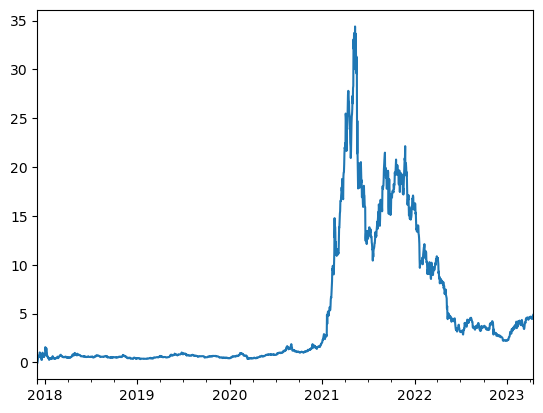

In [54]:
(momentum_result_dict['SAT']['Long_Q5'] - momentum_result_dict['SAT']["Long_Q1"]).fillna(0).plot()
#momentum_result_dict['FRI']["LS"].plot()
#plt.legend(['5-1', 'ls'])

In [49]:
import statsmodels.api as sm
date = 'SUN'

for what in ['Long_Q1','Long_Q2', 'Long_Q3', 'Long_Q4', 'Long_Q5', 'LS']:
    if what == 'LS':
        pf = momentum_result_dict[date]['Long_Q5'] - momentum_result_dict[date]["Long_Q1"]
    
    pf = momentum_result_dict[date][what]
    pf.loc['2017-12-01'] = 1
    pf.sort_index(inplace=True)

    y_values = pf.pct_change(7).fillna(0).resample(f'W-{date}').last().iloc[1:]
    x_values = ((mkt + 1).resample(f'W-{date}').prod() - 1).loc[y_values.index]

    df = pd.concat([y_values, x_values], 
              axis=1,
              keys=['pf', 'mkt'])
    
    X = df['mkt']
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    y = df['pf']

    # Run the regression
    model = sm.OLS(y, X)
    results = model.fit()

    # Adjust the standard errors using Newey-West with `maxlags`
    results_nw = results.get_robustcov_results(cov_type='HAC', use_t=True, maxlags=0)

    # Get the coefficient for the constant
    const_coef = results_nw.params[0]
    const_tstats = results_nw.tvalues[0]
    coefficients = results_nw.params

    print(f"{what}", "coef:", round(const_coef, 4), " / t-stats:", round(const_tstats, 4))
    print(coefficients) 

Long_Q1 coef: -0.0208  / t-stats: -3.9041
[-0.02075671  1.1774376 ]
Long_Q2 coef: -0.0062  / t-stats: -1.4135
[-0.00620742  1.06807372]
Long_Q3 coef: -0.0018  / t-stats: -0.6288
[-0.00182688  1.04458328]
Long_Q4 coef: 0.0024  / t-stats: 0.7191
[0.00242486 1.20030821]
Long_Q5 coef: 0.0049  / t-stats: 1.0414
[0.00487929 1.02945051]
LS coef: 0.0439  / t-stats: 2.4032
[ 0.04389361 -0.16267959]


In [ ]:
for long_ in momentum_result_dict_c2['MON'].keys():
    feature = momentum_result_dict_c2[f'{day}'][long_].pct_change(7).fillna(0).resample(f'W-{day}').last().iloc[1:]
    label = ((mkt + 1).resample(f'W-{day}').prod() - 1).loc[feature.index]

            df = pd.concat([feature, label], axis=1, keys=['y', 'X'])
            small_dict[long_] = df

        result_dict[day] = small_dict

    import statsmodels.api as sm

    for what in ['Q1','Q2', 'Q3', 'Q4', 'Q5', 'LS']:
        q1 = []
        for day, data_dict in result_dict.items():
            for pos, dic in data_dict.items():
                if what in pos:
                    q1.append(dic)

        df = pd.concat(q1)
        df = df.replace(0, np.nan).dropna()     

        # Prepare the data
        X = df['X']
        X = sm.add_constant(X)  # Adds a constant term to the predictor
        y = df['y']

        # Run the regression
        model = sm.OLS(y, X)
        results = model.fit()

        # Adjust the standard errors using Newey-West with `maxlags`
        results_nw = results.get_robustcov_results(cov_type='HAC', use_t=True, maxlags=n)

        # Get the coefficient for the constant
        const_coef = results_nw.params[0]
        const_tstats = results_nw.tvalues[0]
        coefficients = results_nw.params

        print(f"{what}", "coef:", round(const_coef, 4), " / t-stats:", round(const_tstats, 4))
        print(coefficients)